In [2]:
!pip install torch torchvision matplotlib numpy tqdm





Device: cpu


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


100%|██████████| 9.91M/9.91M [00:00<00:00, 56.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.73MB/s]


Training samples: 60000


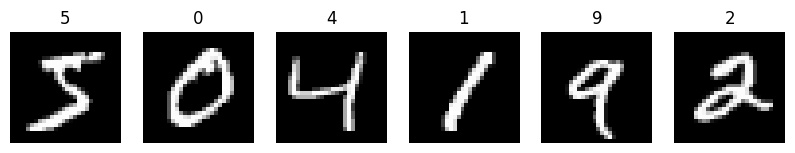

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)  # de [0,1] a [-1,1]
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print("Training samples:", len(dataset))

# Mostrar imágenes
fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i in range(6):
    img, label = dataset[i]
    axes[i].imshow((img.squeeze() + 1) / 2, cmap="gray")  # reescala a [0,1]
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()


In [4]:
T = 300  # número de pasos de ruido

beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

betas, alphas, alpha_bars = betas.to(device), alphas.to(device), alpha_bars.to(device)

def sample_xt(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)
    return torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise, noise


In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.lin1 = nn.Linear(1, dim)
        self.lin2 = nn.Linear(dim, dim)

    def forward(self, t):
        t = t.float().unsqueeze(1)
        x = F.relu(self.lin1(t))
        x = F.relu(self.lin2(x))
        return x

class SimpleUNet(nn.Module):
    def __init__(self, time_dim=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 1, 3, padding=1)
        self.fc_time1 = nn.Linear(time_dim, 64)
        self.fc_time2 = nn.Linear(time_dim, 32)

    def forward(self, x, t):
        temb = self.time_mlp(t)
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(h1))
        h3 = F.relu(self.conv3(h2))
        h3 = h3 + self.fc_time1(temb).view(-1, 64, 1, 1)
        h4 = F.relu(self.conv4(h3))
        h4 = h4 + self.fc_time2(temb).view(-1, 32, 1, 1)
        out = self.conv5(h4)
        return out


In [6]:
model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 3  # puedes aumentar después
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    for x0, _ in tqdm(dataloader, desc=f"Epoch {epoch}"):
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device).long()
        x_t, noise = sample_xt(x0, t)
        noise_pred = model(x_t, t)
        loss = criterion(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x0.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch} - Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 469/469 [08:23<00:00,  1.07s/it]


Epoch 1 - Loss: 1.9672


Epoch 2: 100%|██████████| 469/469 [08:19<00:00,  1.07s/it]


Epoch 2 - Loss: 0.1164


Epoch 3: 100%|██████████| 469/469 [08:23<00:00,  1.07s/it]

Epoch 3 - Loss: 0.0934


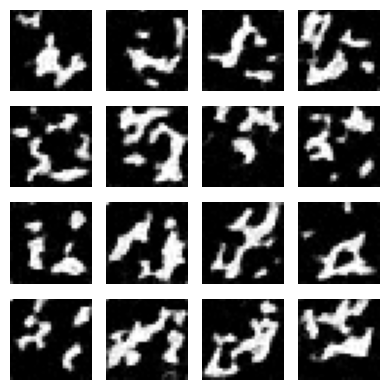

In [7]:
@torch.no_grad()
def sample(model, n_samples=16):
    model.eval()
    x = torch.randn(n_samples, 1, 28, 28).to(device)
    for t in reversed(range(T)):
        t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)
        eps_theta = model(x, t_tensor)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        x = (1 / torch.sqrt(alpha_t)) * (x - beta_t / torch.sqrt(1 - alpha_bar_t) * eps_theta)
        if t > 0:
            z = torch.randn_like(x)
            x = x + torch.sqrt(beta_t) * z
    x = torch.clamp((x + 1) / 2, 0, 1)
    return x.cpu()

samples = sample(model)
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()
